In [2]:
from PIL import Image #PIL - biblioteca Pillow
import os #permite que o Python realize interações com o sistema operacional e gerenciamento de arquivos
import json
import time

import pickle as pkl #bibliteca para serializar (salvar) objetos python em arquivo

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image #Redimensionamento das imagens
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #one hot encoding
from sklearn.model_selection import StratifiedKFold
from keras.applications.mobilenet import preprocess_input #Pré-processamento específico da MobileNet (normalização) à imagem
from keras.applications.resnet50 import preprocess_input as resnet_preprocess_input #precisa colocar o "as" para não sobrescrever a função preprocess_input da MobileNET
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split #Separação em treino e teste

#Treinamento do modelo
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout
from keras.applications import MobileNet, ResNet50
from keras.models import Model
import keras.backend as K #suporte para diversas operações matemáticas, manipulação de tensores, etc.

#Métricas
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, classification_report, precision_score

In [3]:
import pickle

# Carregando a variável do arquivo
with open('/kaggle/input/takeo-data/New_I.pkl', 'rb') as arquivo:
    x_orig = pickle.load(arquivo)

with open('/kaggle/input/takeo-data/New_Y.pkl', 'rb') as arquivo:
    y_orig = pickle.load(arquivo)
    
with open('/kaggle/input/takeo-data/New_M_1.pkl', 'rb') as arquivo:
    m_orig = pickle.load(arquivo)

In [4]:
x_orig = np.array(x_orig)
y_orig = np.array(y_orig)
m_orig = np.array(m_orig)

In [5]:
# Calcular o número de imagens na lista imagens
total_imagens = len(x_orig)

# Imprimir o número total de imagens
print(f"Total de imagens: {total_imagens}")

Total de imagens: 10022


In [6]:
# Calcular o número de máscaras
total_imagens = len(m_orig)

# Imprimir o número total de imagens
print(f"Total de masks: {total_imagens}")

Total de masks: 10022


In [7]:
import cv2
import numpy as np

# Supondo que 'm_orig' seja uma lista ou array de máscaras
bounding_boxes = []

for index, mask in enumerate(m_orig):
    # Encontrar contornos na máscara
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calcular bounding box para cada contorno
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x+w, y+h))

print(f"Total de bounding boxes: {len(bounding_boxes)}")



Total de bounding boxes: 10143


In [8]:
import cv2
import numpy as np

def contar_contornos_em_mascaras(mascaras):
    # Dicionário para contar a quantidade de máscaras por número de contornos
    contagem_contornos = {}

    for mask in mascaras:
        # Assegurar que a máscara esteja em formato uint8
        if mask.dtype != np.uint8:
            mask = mask.astype(np.uint8)

        # Encontrar contornos
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Contar quantos contornos foram encontrados
        num_contornos = len(contours)

        # Atualizar o dicionário de contagem
        if num_contornos in contagem_contornos:
            contagem_contornos[num_contornos] += 1
        else:
            contagem_contornos[num_contornos] = 1

    return contagem_contornos

# Chamar a função passando a lista completa de máscaras
resultado_contagem = contar_contornos_em_mascaras(m_orig)
print("Contagem de máscaras por número de contornos:", resultado_contagem)



Contagem de máscaras por número de contornos: {1: 9947, 3: 10, 5: 4, 2: 53, 6: 2, 4: 5, 8: 1}


In [9]:
import cv2
import numpy as np

# Identificar os índices das máscaras com mais de um contorno
indices_para_remover = []

for index, mask in enumerate(m_orig):
    # Converter para uint8 se necessário
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Encontrar contornos
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Checar se há mais de um contorno
    if len(contours) > 1:
        indices_para_remover.append(index)

# Remover as imagens, labels e máscaras correspondentes aos índices identificados
x_orig = [x for i, x in enumerate(x_orig) if i not in indices_para_remover]
y_orig = [y for i, y in enumerate(y_orig) if i not in indices_para_remover]
m_orig = [m for i, m in enumerate(m_orig) if i not in indices_para_remover]

# Impressão para verificar os resultados após a remoção
print(f"Total de imagens restantes: {len(x_orig)}")
print(f"Total de labels restantes: {len(y_orig)}")
print(f"Total de máscaras restantes: {len(m_orig)}")


Total de imagens restantes: 9947
Total de labels restantes: 9947
Total de máscaras restantes: 9947


Total de bounding boxes: 9947


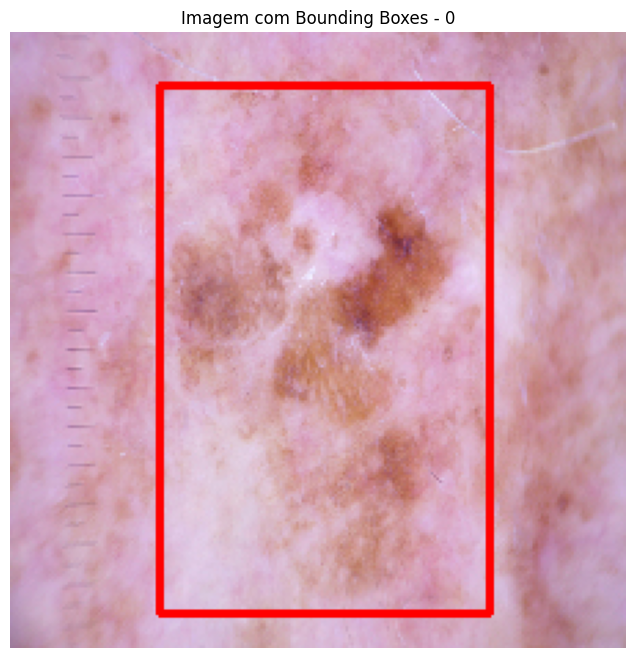

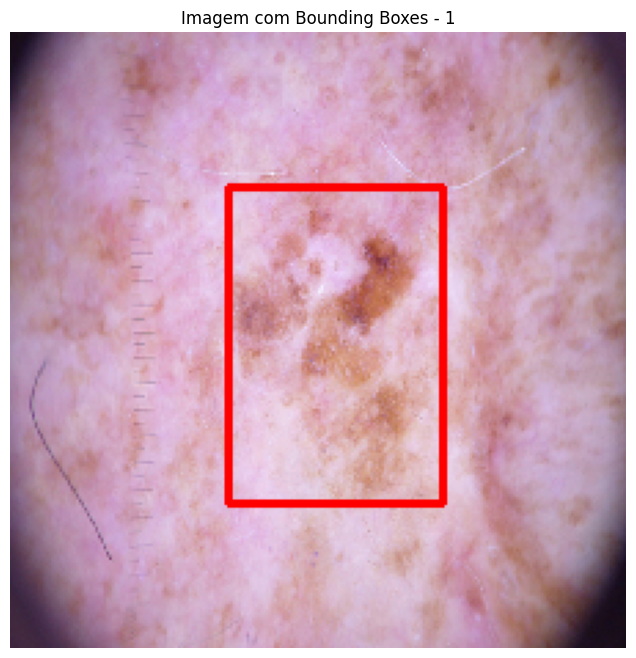

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Supondo que 'm_orig' seja uma lista ou array de máscaras
bounding_boxes = []

# Calcular bounding boxes para todas as máscaras
for index, mask in enumerate(m_orig):
    # Encontrar contornos na máscara
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calcular bounding box para cada contorno
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x+w, y+h))

# Exibir o total de bounding boxes calculados
print(f"Total de bounding boxes: {len(bounding_boxes)}")

# Visualizar apenas as duas primeiras imagens com bounding boxes
for index in range(2):  # Mudar para range(2) para processar apenas duas imagens
    if index < len(m_orig):  # Verifica se o índice está dentro do alcance
        mask = m_orig[index]
        image = x_orig[index].copy()

        # Encontrar contornos na máscara
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Converter para RGB se for necessário
        if len(image.shape) == 2 or image.shape[2] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Desenhar bounding box para cada contorno
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Mostrar imagem com bounding boxes
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Imagem com Bounding Boxes - {index}")
        plt.axis('off')
        plt.show()


In [17]:
import cv2
import matplotlib.pyplot as plt

def verificar_e_recortar_imagens(imagens_carregadas, bboxs):
    imagens_recortadas = []
    imagens_com_bbox = []
    
    for index, (imagem, bbox) in enumerate(zip(imagens_carregadas, bboxs)):
        xmin, ymin, xmax, ymax = bbox  # Coordenadas do bounding box
        width = xmax - xmin
        height = ymax - ymin

        # Recortar a imagem
        imagem_recortada = imagem[ymin:ymax, xmin:xmax]
        imagens_recortadas.append(imagem_recortada)

        # Desenhar o bounding box na imagem original para verificar
        imagem_com_bbox = imagem.copy()
        cv2.rectangle(imagem_com_bbox, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        imagens_com_bbox.append(imagem_com_bbox)

        # Limitar a visualização às primeiras 5 imagens
    plt.figure(figsize=(20, 4))
    for i in range(min(5, len(imagens_com_bbox))):
        plt.subplot(1, 5, i + 1)
        plt.imshow(imagens_com_bbox[i])
        plt.title(f"Verificação {i}")
        plt.axis('off')
    plt.show()

    return imagens_recortadas






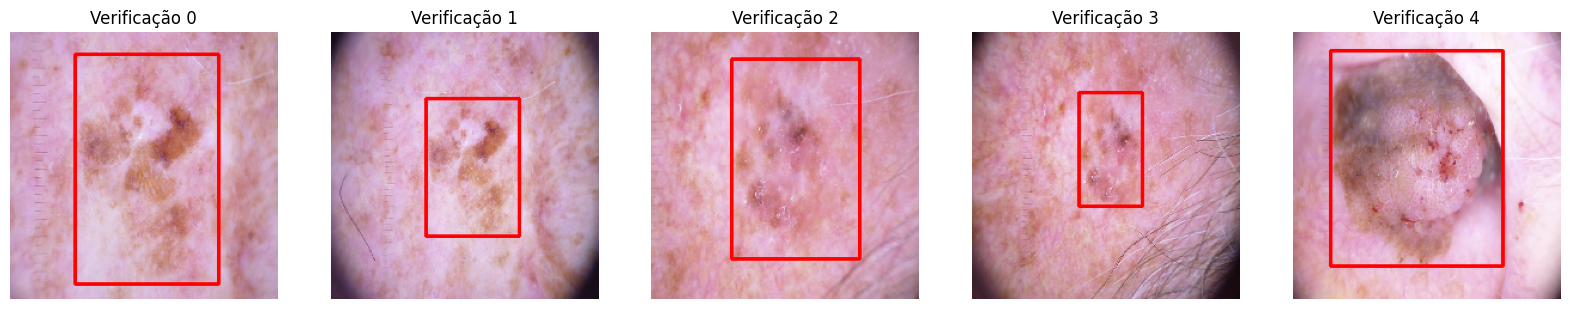

In [18]:
imagens_recortadas = verificar_e_recortar_imagens(x_orig,bounding_boxes )

In [20]:
# Calcular o número de imagens na lista imagens_recortadas
total_imagens = len(imagens_recortadas)

# Imprimir o número total de imagens
print(f"Total de imagens recortadas: {total_imagens}")


Total de imagens recortadas: 9947


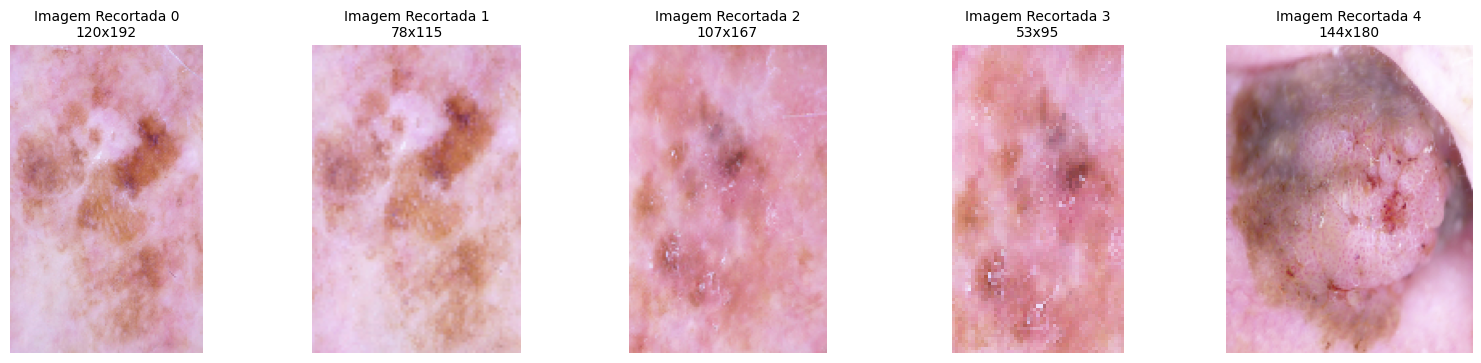

In [28]:
import matplotlib.pyplot as plt

# Plotar as primeiras cinco imagens recortadas para verificação, uma ao lado da outra
plt.figure(figsize=(20, 4))
for i, img_recortada in enumerate(imagens_recortadas[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_recortada)
    height, width = img_recortada.shape[:2]
    plt.title(f"Imagem Recortada {i}\n{width}x{height}", fontsize=10)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.2)  # Ajusta o espaçamento entre os subplots
plt.show()

In [29]:
import cv2

def redimensionar_imagens(imagens, novo_tamanho=(100, 100), metodo_interpolacao=cv2.INTER_NEAREST):
    imagens_redimensionadas = []
    for imagem in imagens:
        # Redimensionar a imagem para o novo tamanho usando o método de interpolação especificado
        imagem_redimensionada = cv2.resize(imagem, novo_tamanho, interpolation=metodo_interpolacao)
        imagens_redimensionadas.append(imagem_redimensionada)
    return imagens_redimensionadas

# Redimensionar as imagens recortadas
imagens_redimensionadas = redimensionar_imagens(imagens_recortadas)


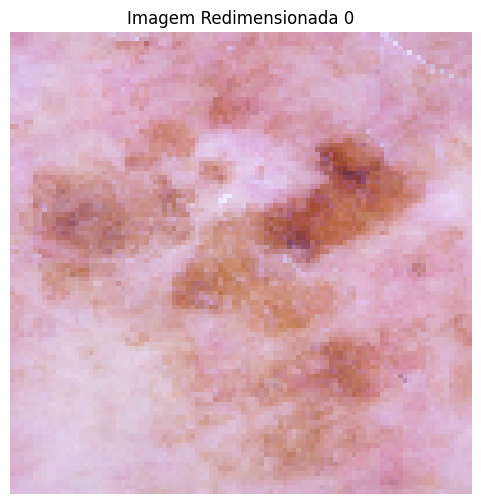

Tamanho da Imagem Redimensionada 0: 100x100


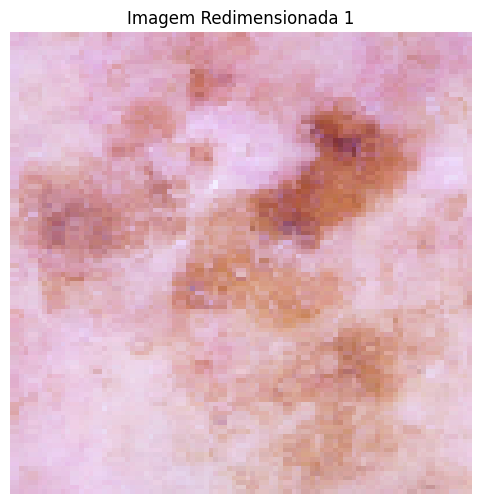

Tamanho da Imagem Redimensionada 1: 100x100


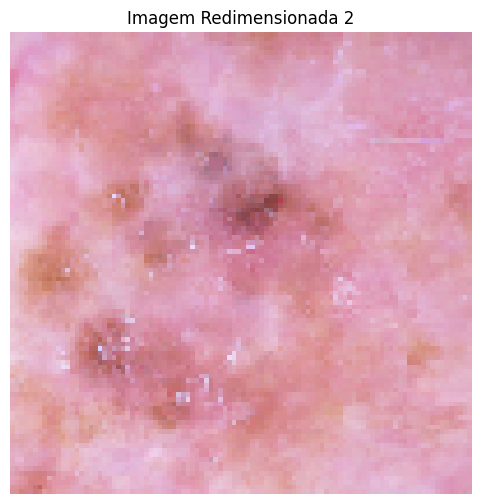

Tamanho da Imagem Redimensionada 2: 100x100


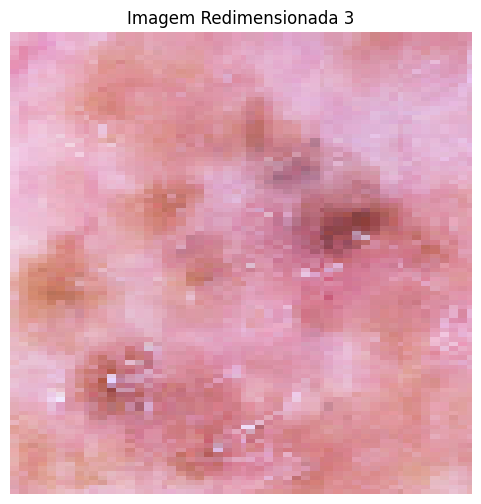

Tamanho da Imagem Redimensionada 3: 100x100


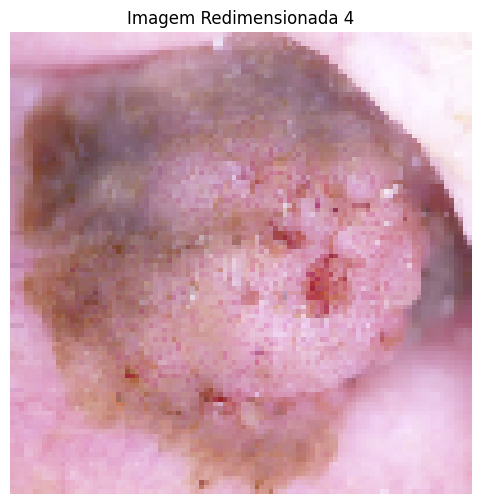

Tamanho da Imagem Redimensionada 4: 100x100


In [30]:
# Plotar as primeiras duas imagens redimensionadas para verificação
for i, img_redimensionada in enumerate(imagens_redimensionadas[:5]):
    plt.figure(figsize=(6, 6))
    plt.imshow(img_redimensionada)
    plt.title(f"Imagem Redimensionada {i}")
    plt.axis('off')
    plt.show()
    print(f"Tamanho da Imagem Redimensionada {i}: {img_redimensionada.shape[0]}x{img_redimensionada.shape[1]}")



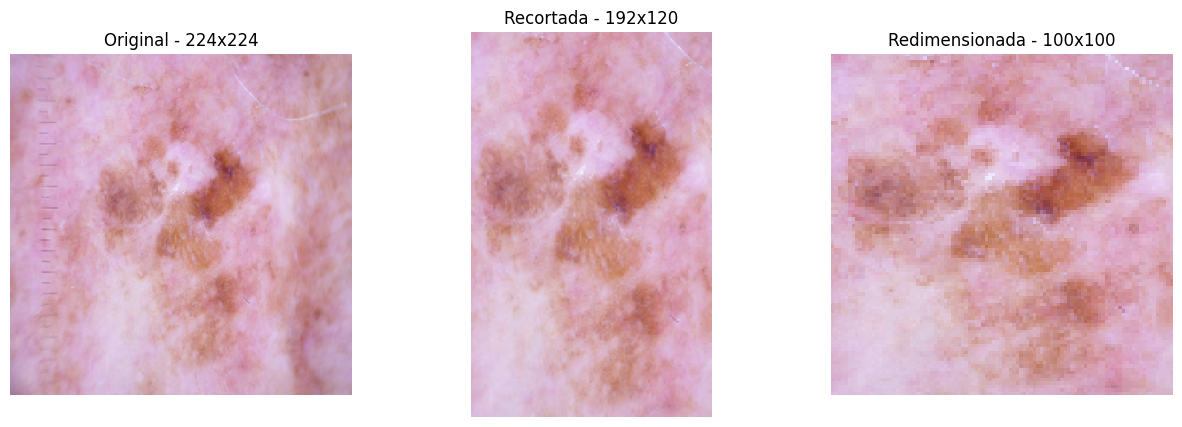

In [31]:
import matplotlib.pyplot as plt

n_imagens = 1  # Configurar para o número de imagens que você quer mostrar

for i in range(n_imagens):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Três colunas para as três imagens

    # Imagem original
    axs[0].imshow(x_orig[i])
    axs[0].set_title(f"Original - {x_orig[i].shape[0]}x{x_orig[i].shape[1]}")
    axs[0].axis('off')

    # Imagem recortada
    axs[1].imshow(imagens_recortadas[i])
    axs[1].set_title(f"Recortada - {imagens_recortadas[i].shape[0]}x{imagens_recortadas[i].shape[1]}")
    axs[1].axis('off')

    # Imagem redimensionada
    axs[2].imshow(imagens_redimensionadas[i])
    axs[2].set_title(f"Redimensionada - {imagens_redimensionadas[i].shape[0]}x{imagens_redimensionadas[i].shape[1]}")
    axs[2].axis('off')

    plt.show()


In [32]:
# Suponha que imagens_redimensionadas seja uma lista de arrays NumPy, cada um representando uma imagem redimensionada
# Imprimir o número total de imagens na lista
print("Número total de imagens redimensionadas:", len(imagens_redimensionadas))

Número total de imagens redimensionadas: 9947


In [33]:
import pickle

# Assumindo que imagens_redimensionadas é o seu array já existente
# Definir o caminho do arquivo onde os dados serão salvos
caminho_arquivo = '/kaggle/working/imagens_redimensionadas.pkl'  # Ajuste o caminho conforme necessário

# Abrir o arquivo para escrita em modo binário e salvar o array
with open(caminho_arquivo, 'wb') as arquivo:
    pickle.dump(imagens_redimensionadas, arquivo)

print(f"Array de imagens redimensionadas salvo em: {caminho_arquivo}")


Array de imagens redimensionadas salvo em: /kaggle/working/imagens_redimensionadas.pkl


In [34]:
# Assumindo que imagens_redimensionadas é o seu array já existente
# Definir o caminho do arquivo onde os dados serão salvos
caminho_arquivo = '/kaggle/working/x_orig_mod.pkl'  # Ajuste o caminho conforme necessário

# Abrir o arquivo para escrita em modo binário e salvar o array
with open(caminho_arquivo, 'wb') as arquivo:
    pickle.dump(x_orig, arquivo)

print(f"Array de imagens salvo em: {caminho_arquivo}")

Array de imagens salvo em: /kaggle/working/x_orig_mod.pkl


In [37]:
# Assumindo que imagens_redimensionadas é o seu array já existente
# Definir o caminho do arquivo onde os dados serão salvos
caminho_arquivo = '/kaggle/working/y_orig_mod.pkl'  # Ajuste o caminho conforme necessário

# Abrir o arquivo para escrita em modo binário e salvar o array
with open(caminho_arquivo, 'wb') as arquivo:
    pickle.dump(y_orig, arquivo)

print(f"Array de labels salvo em: {caminho_arquivo}")

Array de labels salvo em: /kaggle/working/y_orig_mod.pkl


In [38]:
# Assumindo que imagens_redimensionadas é o seu array já existente
# Definir o caminho do arquivo onde os dados serão salvos
caminho_arquivo = '/kaggle/working/x_recortado_noresize.pkl'  # Ajuste o caminho conforme necessário

# Abrir o arquivo para escrita em modo binário e salvar o array
with open(caminho_arquivo, 'wb') as arquivo:
    pickle.dump(imagens_recortadas, arquivo)

print(f"Array de labels salvo em: {caminho_arquivo}")

Array de labels salvo em: /kaggle/working/x_recortado_noresize.pkl


In [39]:
import numpy as np

# Suponha que imagens_redimensionadas seja uma lista de arrays NumPy, cada um representando uma imagem redimensionada
# Converter a lista de imagens para um único array NumPy
array_imagens = np.stack(imagens_redimensionadas)

# Imprimir o shape do array NumPy resultante
print("Shape do array de imagens redimensionadas:", array_imagens.shape)


Shape do array de imagens redimensionadas: (9947, 100, 100, 3)


In [40]:
# Assumindo que imagens_redimensionadas é o seu array já existente
# Definir o caminho do arquivo onde os dados serão salvos
caminho_arquivo = '/kaggle/working/m_orig_mod.pkl'  # Ajuste o caminho conforme necessário

# Abrir o arquivo para escrita em modo binário e salvar o array
with open(caminho_arquivo, 'wb') as arquivo:
    pickle.dump(m_orig, arquivo)

print(f"Array de masks salvo em: {caminho_arquivo}")

Array de masks salvo em: /kaggle/working/m_orig_mod.pkl


In [41]:
# Suponha que imagens_redimensionadas seja uma lista de arrays NumPy, cada um representando uma imagem redimensionada
# Converter a lista de imagens para um único array NumPy
array_imagens = np.stack(x_orig)

# Imprimir o shape do array NumPy resultante
print("Shape do array de imagens:", array_imagens.shape)


Shape do array de imagens: (9947, 224, 224, 3)


In [42]:
# Suponha que imagens_redimensionadas seja uma lista de arrays NumPy, cada um representando uma imagem redimensionada
# Converter a lista de imagens para um único array NumPy
array_imagens = np.stack(y_orig)

# Imprimir o shape do array NumPy resultante
print("Shape do array de labels:", array_imagens.shape)


Shape do array de labels: (9947,)


In [43]:
# Suponha que imagens_redimensionadas seja uma lista de arrays NumPy, cada um representando uma imagem redimensionada
# Converter a lista de imagens para um único array NumPy
array_imagens = np.stack(m_orig)

# Imprimir o shape do array NumPy resultante
print("Shape do array de masks:", array_imagens.shape)


Shape do array de masks: (9947, 224, 224)
